In [8]:
from spin_sim_src import *
import pickle as pickle

if __name__ == "__main__":
    print("This is main.py\n")

    # run: python <filename>.py <unique_number> <tfinal> <timesteps> <B0_start> <B0_stop> <B_steps>
    # <theta_start> <theta_stop> <theta_steps>
    #
    # theta is in units of pi
    #
    # for example: python cluster_do_colorplot.py 001 0.5e-3 500 0 1000e-6 100 0 1 100

    # transform command line arguments into the parameters  8 1.0e-3 100 0.0 1000.e-6 10 0.0 2.0 10

    unique_number = 8.
    tfinal = 1.0e-3
    timesteps = 100

    B_start = 0.0
    B_stop = 1000.0e-6
    B_steps = 10

    theta_start = 0.0 * np.pi
    theta_stop = 2.0 * np.pi
    theta_steps = 10

    # B0 = 47e-6 #T, B field of Earth at Frankfurt
    # theta = np.pi/4.0 #inclination of B field wrt to axis of RP, [0,pi]

    phi = 0. * np.pi / 1.0  # azimuth of B field, , [0,2*pi]

    mu0h = 9.274e-24 / 6.6e-34  # mu0 / h, 1/(T*s)
    a = [0., 0., 0.]
    a[0] = mu0h * 0.345e-4  # 0.345G given by PRE ; ax is now in Hz
    a[1] = mu0h * 0.345e-4  # 0.345G given by PRE ; ay is now in Hz
    a[2] = mu0h * 9e-4  # 9G given by PRE ; az is now in Hz
    # "Biologically feasible regime of HF strengths, 0.1 to 10G, see ref 26 in PRE"

    k = [0., 0., 0., 0.]
    k[0] = 2e4  # Hz, rate of decay into |S>
    k[1] = 2e4  # Hz, rate of decay into |T->
    k[2] = 2e4  # Hz, rate of decay into |T0>
    k[3] = 2e4  # Hz, rate of decay into |T+>

    # time array to simulate
    tinit = 0.0
    # tfinal = 1.0e-3
    # notimepoints = 1000.0

    times = np.linspace(tinit, tfinal, timesteps)  # in seconds
    timedetail = (tfinal - tinit) / timesteps
    # time zero is creation of RP

    num_states = 12

    # preparing the initial density matrices for various scenarios
    rho0_vectors, rho0_description = prep_ini_state()

    # adding dimensions to rho0 to account for the shelving states
    rho0 = rho_add_dim(total_num_states=num_states, rho0_vector=rho0_vectors[1])

    # coupling to bath or decay operators
    c_op_list = []

    P1 = 1.0 / np.sqrt(2.0) * basis(num_states, 8) * (basis(num_states, 2).dag() - basis(num_states, 4).dag())
    P2 = 1.0 / np.sqrt(2.0) * basis(num_states, 8) * (basis(num_states, 3).dag() - basis(num_states, 5).dag())
    P3 = 1.0 / np.sqrt(2.0) * basis(num_states, 10) * (basis(num_states, 2).dag() + basis(num_states, 4).dag())
    P4 = 1.0 / np.sqrt(2.0) * basis(num_states, 10) * (basis(num_states, 3).dag() + basis(num_states, 5).dag())
    P5 = basis(num_states, 11) * basis(num_states, 0).dag()
    P6 = basis(num_states, 11) * basis(num_states, 1).dag()
    P7 = basis(num_states, 9) * basis(num_states, 6).dag()
    P8 = basis(num_states, 9) * basis(num_states, 7).dag()

    c_op_list.append(np.sqrt(k[0]) * P1)
    c_op_list.append(np.sqrt(k[0]) * P2)
    c_op_list.append(np.sqrt(k[1]) * P3)
    c_op_list.append(np.sqrt(k[1]) * P4)
    c_op_list.append(np.sqrt(k[2]) * P5)
    c_op_list.append(np.sqrt(k[2]) * P6)
    c_op_list.append(np.sqrt(k[3]) * P7)
    c_op_list.append(np.sqrt(k[3]) * P8)

    ex_op_list = []

    # define the arrays to calculate the B-field and the theta angles
    do_log_bfield_scan = False
    if do_log_bfield_scan:
        B0_arr = np.logspace(np.log10(B_start), np.log10(B_stop), B_steps)  # in T, 100 is usual
    else:
        B0_arr = np.linspace(B_start, B_stop, B_steps)  # in T, 100 is usual

    theta_arr = np.linspace(theta_start, theta_stop, theta_steps)  # rad, 100 is usual

    result_S = []
    result_S_formula = []
    # pops_tot = np.zeros([len(B0_arr), len(theta_arr), len(times), number_of_states])
    pops_tot = np.zeros([len(B0_arr), len(theta_arr), num_states])

    l0 = 0

    for B0 in B0_arr:

        l1 = 0

        print("B-field = " + str(B0))

        for theta in theta_arr:
            print("   Theta = " + str(theta))

            # building the Hamiltonian
            h = build_Hamiltonian(a, B0, theta, phi)

            # adding the shelving states as additional dimensions to the Hamiltonian
            H = hamiltonian_add_dim(total_num_states=num_states, hamiltonian=h)

            SYend, SYform, pops = time_evol(H, rho0, num_states, times, timesteps, timedetail, k, c_op_list, ex_op_list)
            result_S.append(SYend)
            result_S_formula.append(SYform)
            # pops_tot[l0,l1,:,:] = pops
            pops_tot[l0, l1, :] = pops[-1, :]  # only save the last time point

            l1 += 1

        l0 += 1

    pickle.dump([result_S, result_S_formula, pops_tot, B0_arr, theta_arr, phi, a[0], a[1], a[2], k[0], k[1], tfinal,
                 timedetail, rho0], open("Data_" + rho0_description[1] + ".p", "wb"))

    print("Done.")


This is main.py

B-field = 0.0
   Theta = 0.0
   Theta = 0.6981317007977318
   Theta = 1.3962634015954636
   Theta = 2.0943951023931953
   Theta = 2.792526803190927
   Theta = 3.490658503988659
   Theta = 4.1887902047863905
   Theta = 4.886921905584122
   Theta = 5.585053606381854
   Theta = 6.283185307179586
B-field = 0.00011111111111111112
   Theta = 0.0
   Theta = 0.6981317007977318
   Theta = 1.3962634015954636
   Theta = 2.0943951023931953
   Theta = 2.792526803190927
   Theta = 3.490658503988659
   Theta = 4.1887902047863905
   Theta = 4.886921905584122
   Theta = 5.585053606381854
   Theta = 6.283185307179586
B-field = 0.00022222222222222223
   Theta = 0.0
   Theta = 0.6981317007977318
   Theta = 1.3962634015954636
   Theta = 2.0943951023931953
   Theta = 2.792526803190927
   Theta = 3.490658503988659
   Theta = 4.1887902047863905
   Theta = 4.886921905584122
   Theta = 5.585053606381854
   Theta = 6.283185307179586
B-field = 0.0003333333333333334
   Theta = 0.0
   Theta = 0.698

/Users/reza/anaconda3/envs/spin_sim/lib/python3.7/site-packages/scipy/integrate/_ode.py:1012: UserWarning: zvode: Excess work done on this call. (Perhaps wrong MF.)
  self.messages.get(istate, unexpected_istate_msg)))


   Theta = 3.490658503988659
   Theta = 4.1887902047863905
excepted
   Theta = 4.886921905584122
excepted
   Theta = 5.585053606381854
excepted
   Theta = 6.283185307179586
B-field = 0.00044444444444444447
   Theta = 0.0
   Theta = 0.6981317007977318
excepted
   Theta = 1.3962634015954636
excepted
   Theta = 2.0943951023931953
excepted
   Theta = 2.792526803190927
excepted
   Theta = 3.490658503988659
excepted
   Theta = 4.1887902047863905
excepted
   Theta = 4.886921905584122
excepted
   Theta = 5.585053606381854
excepted
   Theta = 6.283185307179586
B-field = 0.0005555555555555556
   Theta = 0.0
excepted
   Theta = 0.6981317007977318
excepted
   Theta = 1.3962634015954636
excepted
   Theta = 2.0943951023931953
excepted
   Theta = 2.792526803190927
excepted
   Theta = 3.490658503988659
excepted
   Theta = 4.1887902047863905
excepted
   Theta = 4.886921905584122
excepted
   Theta = 5.585053606381854
excepted
   Theta = 6.283185307179586
excepted
B-field = 0.0006666666666666668
   Theta

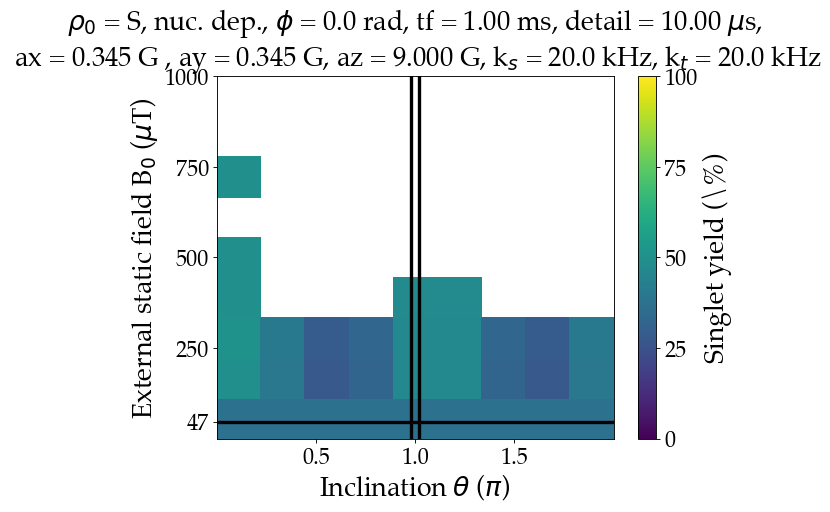

NameError: name 'ax' is not defined

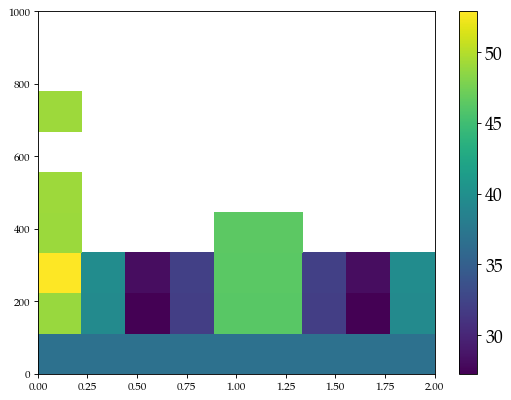

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
#sys.path.append("/usr/bin") # necessary for the tex fonts
#sys.path.append("../Python modules/") # necessary for the tex fonts

fsizetit = 24
fsizepl = 20
sizex = 8
sizey = 6
fsizenb = 16
dpi_no = 80
lw = 2

mu0h = 9.274e-24/6.6e-34 #mu0 / h, 1/(T*s)
phi = 0.0
###############################################################################

data = pickle.load(open( "Data_S, nuc. dep..p", "rb" ))
rho0_description = 'S, nuc. dep.'
#data = pickle.load( open( "Data_Elecs. dep., nuc. dep._complete.p", "rb" ) ,encoding='latin1')
#data = pickle.load( open( "Data_Tzero, nuc. dep._complete.p", "rb" ) ,encoding='latin1')
#data = pickle.load( open( "Data_Tminus, nuc. dep._complete.p", "rb" ) ,encoding='latin1')
#data = pickle.load( open( "Data_Tplus, nuc. dep._complete.p", "rb" ) ,encoding='latin1')

#for k in [8,9,10,11]:
#    plt.figure()
#    plt.imshow(d[2][:, :, k])
#    plt.colorbar()
#    plt.title('State: ' + str(k))
#
#plt.show()


result_S = 100*np.array(data[0]).reshape(len(data[3]),len(data[4]))
result_S_formula = 100*np.array(data[1]).reshape(len(data[3]),len(data[4]))

#fig 1 
plt.figure(figsize=(sizex, sizey), dpi=dpi_no)
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('font', serif='Palatino')  
plt.pcolor(data[4]/np.pi,data[3]*1e6,result_S,vmin=0, vmax=100) 
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=fsizepl)
plt.title(r'$\rho_0$ = ' + rho0_description + ', $\phi$ = ' + str("{0:.1f}".format(data[5])) + ' rad, ' + r'tf = ' +  str("{0:.2f}".format(data[11]*1e3)) + ' ms, detail = ' + str("{0:.2f}".format(data[12]*1e6)) + r' $\mu$s,' + '\n ax = ' + str("{0:.3f}".format(data[6]/mu0h*1e4)) + ' G , ay = ' + str("{0:.3f}".format(data[7]/mu0h*1e4)) + ' G, az = ' + str("{0:.3f}".format(data[8]/mu0h*1e4)) + ' G, ' + r'k$_s$ = ' + str("{0:.1f}".format(data[9]/1000.0)) + ' kHz, ' + 'k$_t$ = ' + str("{0:.1f}".format(data[10]/1000.0)) + ' kHz', fontsize = fsizetit)
plt.ylabel(r'External static field B$_0$ ($\mu$T)',fontsize = fsizetit)
plt.xlabel(r'Inclination $\theta$ ($\pi$)',fontsize = fsizetit)
cbar.ax.set_ylabel(r'Singlet yield (\%)',fontsize = fsizetit)
cbar.set_ticks([0, 25, 50, 75, 100])
plt.xticks([0.5, 1, 1.5],fontsize=fsizepl)
plt.yticks([47, 250, 500,750, 1000],fontsize=fsizepl)
plt.axhline(y=47, xmin=0, xmax=2*np.pi, linewidth=3, color = 'k')
plt.ylim([data[3][0]*1e6,data[3][-1]*1e6])
plt.axvline(x=0.98,linewidth=3, color = 'k')
plt.axvline(x=1.02,linewidth=3, color = 'k')


plt.show()



#fig 2 - to check if it's like fig 1
plt.figure(figsize=(sizex, sizey), dpi=dpi_no)
#    plt.rc('text', usetex=True)
#    plt.rc('font', family='serif')
#    plt.rc('font', serif='Palatino')  
plt.pcolor(data[4]/np.pi,data[3]*1e6,result_S_formula) #,cmap='Greys') #, vmin=z_min, vmax=z_max)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=fsizenb)
plt.title(r'$\rho_0$ = ' + rho0_description + ', $\phi$ = ' + str("{0:.1f}".format(phi)) + ' rad, ' + r'tf = ' +  str("{0:.2f}".format(tfinal*1e3)) + ' ms, detail = ' + str("{0:.2f}".format(timedetail*1e6)) + r' $\mu$s,' + '\n ax = ' + str("{0:.3f}".format(ax/mu0h*1e4)) + ' G , ay = ' + str("{0:.3f}".format(ay/mu0h*1e4)) + ' G, az = ' + str("{0:.3f}".format(az/mu0h*1e4)) + ' G, ' + r'k$_s$ = ' + str("{0:.1f}".format(ks/1000.0)) + ' kHz, ' + 'k$_t$ = ' + str("{0:.1f}".format(kt/1000.0)) + ' kHz', fontsize = fsizetit)
plt.ylabel(r'External static field B$_0$ ($\mu$T)',fontsize = fsizepl)
plt.xlabel(r'Inclination $\theta$ ($\pi$)',fontsize = fsizepl)
cbar.ax.set_ylabel(r'Singlet yield (\%)',fontsize = fsizepl)
plt.xticks(fontsize=fsizenb)
plt.yticks(fontsize=fsizenb)


#fig 3
plt.figure(figsize=(sizex, sizey), dpi=dpi_no)
#    plt.rc('text', usetex=True)
#    plt.rc('font', family='serif')
#    plt.rc('font', serif='Palatino')  
plt.plot(data[3]*1e6, np.nanmax(result_S, axis = 1)-np.nanmin(result_S, axis = 1)) #Sensitivity vs B0
plt.legend()
plt.xlabel(r'External static field B$_0$ ($\mu$T)',fontsize = fsizepl)
plt.ylabel(r'Sensitivity (\%)',fontsize = fsizepl)
plt.ylim([0,25])
plt.xlim([0,1000])
plt.xticks(fontsize=fsizenb)
plt.yticks(fontsize=fsizenb)
plt.title(r'$\rho_0$ = ' + rho0_description + ', $\phi$ = ' + str("{0:.1f}".format(phi)) + ' rad, ' + r'tf = ' +  str("{0:.2f}".format(tfinal*1e3)) + ' ms, detail = ' + str("{0:.1f}".format(timedetail*1e6)) + r' $\mu$s,' + '\n ax = ' + str("{0:.3f}".format(ax/mu0h*1e4)) + ' G , ay = ' + str("{0:.3f}".format(ay/mu0h*1e4)) + ' G, az = ' + str("{0:.3f}".format(az/mu0h*1e4)) + ' G, ' + r'k$_s$ = ' + str("{0:.1f}".format(ks/1000.0)) + ' kHz, ' + 'k$_t$ = ' + str("{0:.1f}".format(kt/1000.0)) + ' kHz', fontsize = fsizetit)


#    plt.figure(figsize=(sizex, sizey), dpi=dpi_no)
#    plt.rc('text', usetex=True)
#    plt.rc('font', family='serif')
#    plt.rc('font', serif='Palatino')  
#    my_labels = ['uuu','uud','udu','udd','duu','dud','ddu','ddd','S recombined','T$_+$ recombined','T$_0$ recombined','T$_-$ recombined']
#    for k in range(number_of_states):
#        if k > 7:
#            my_ls = '--'
#            my_label = my_labels[k]
#        else:
#            my_label = my_labels[k]
#            
#            my_label = my_label.replace('u',r'$\uparrow$')
#            my_label = my_label.replace('d',r'$\downarrow$')
#    
#            my_ls = '-'
#    
#        plt.plot(times*(1e6), pops_tot[:, k], label = my_label, ls = my_ls)
#    plt.legend()
#    plt.xlabel('Time after RP creation [$\mu$s]')
#    plt.ylabel('Populations')
#    plt.ylim([0,0.52])

multipage(rho0_description[k] + '.pdf')
plt.close("all")

#plt.show()